<a href="https://colab.research.google.com/github/mvince33/Coding-Dojo/blob/main/week08/intro_to_boosting_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [89]:
# Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Load the data

In [90]:
# Load the data
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTaFwcgNqEi1Ukng3W4VNgBxxju-L8tNR0tgFY4ZZxV1rPsx7fwmUYJlYbWlge-y4AKjGWQ_NbJFHrv/pub?output=csv'
df = pd.read_csv(url)
df.head()

,Unnamed: 0,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
0,0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Explore the data

In [91]:
# Explore the data
print('Duplicates:', df.duplicated().sum())
print('Missing Values:', df.isna().sum().sum())

Duplicates: 0
Missing Values: 0


In [92]:
# Drop thu Unnamed: 0 column
df.drop(columns = 'Unnamed: 0', inplace = True)


In [93]:
# Check for inconsistent labels
cat_cols = df.select_dtypes('object')
for col in cat_cols:
  print('Column:', col, '\n')
  print(df[col].value_counts())
  print()

Column: workclass 

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

Column: education 

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

Column: marital-status 

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64

Column: occupation 

Prof-specialt

In [94]:
df.loc[df['native-country'] == 'South', ['race']].value_counts()

race              
Asian-Pac-Islander    77
Amer-Indian-Eskimo     2
White                  1
dtype: int64

> Based on the above, it seems the most reasonable to replace South with South Korea.

In [95]:
# Fix the native-country values
df['native-country'].replace({'South': 'South-Korea', 
                              'Hong': 'Hong-Kong', 
                              'Holand-Netherlands': 'Holland-Netherlands'}, inplace = True)

# Make sure the changes were made
df['native-country'].value_counts()

United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South-Korea                      80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                      

In [96]:
# Check the balance of the target
df['income-class'].value_counts(normalize = True)

<=50K    0.75919
>50K     0.24081
Name: income-class, dtype: float64

# Split the data

In [97]:
# Set the features and target
X = df.drop(columns = 'income-class')
y = df['income-class']

In [98]:
# Split the data. Use stratification due to imbalanced data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

# Construct a modeling pipeline

In [99]:
# Get the datatypes of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   education       32561 non-null  object
 3   marital-status  32561 non-null  object
 4   occupation      32561 non-null  object
 5   relationship    32561 non-null  object
 6   race            32561 non-null  object
 7   sex             32561 non-null  object
 8   capital-gain    32561 non-null  int64 
 9   capital-loss    32561 non-null  int64 
 10  hours-per-week  32561 non-null  int64 
 11  native-country  32561 non-null  object
 12  income-class    32561 non-null  object
dtypes: int64(4), object(9)
memory usage: 3.2+ MB


In [100]:
# Make column selectors
cat_selector = make_column_selector(dtype_include = 'object')
num_selector = make_column_selector(dtype_include = 'number')

In [101]:
# Make tuples for the column transformer
cat_tuple = (OneHotEncoder(sparse = False, handle_unknown = 'ignore'), cat_selector)
num_tuple = (StandardScaler(), num_selector)

In [102]:
# Construct the column transformer
col_transformer = make_column_transformer(cat_tuple, num_tuple, remainder = 'passthrough')

# eXtreme Gradient Boosting

In [103]:
# Instantiate an XBG model  
xgb_pipe = make_pipeline(col_transformer, XGBClassifier())

In [104]:
%%time
# Train the XGB model
xgb_pipe.fit(X_train, y_train)

CPU times: user 5.81 s, sys: 77.9 ms, total: 5.89 s
Wall time: 5.88 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fad38d79950>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fad38f3ff50>)])),
                ('xgbclassifier', XGBClassifier())])

In [105]:
# Evaluate the XGB model
y_train_pred = xgb_pipe.predict(X_train)
y_test_pred = xgb_pipe.predict(X_test)

print(classification_report(y_train, y_train_pred))
print()
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91     18539
        >50K       0.80      0.58      0.67      5881

    accuracy                           0.86     24420
   macro avg       0.84      0.77      0.79     24420
weighted avg       0.86      0.86      0.86     24420


              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      6181
        >50K       0.80      0.58      0.67      1960

    accuracy                           0.86      8141
   macro avg       0.84      0.77      0.79      8141
weighted avg       0.86      0.86      0.86      8141



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


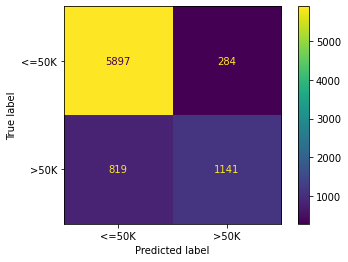

In [106]:
plot_confusion_matrix(xgb_pipe, X_test, y_test)

# LightGBM

In [107]:
# Instantiate a LightGBM model
lgbm_pipe = make_pipeline(col_transformer, LGBMClassifier())

In [108]:
%%time
# Fit the LightGBM model
lgbm_pipe.fit(X_train, y_train)

CPU times: user 555 ms, sys: 11 ms, total: 566 ms
Wall time: 565 ms


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fad38d79950>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fad38f3ff50>)])),
                ('lgbmclassifier', LGBMClassifier())])

In [109]:
# Evaluate the LightGBM model
y_train_pred = lgbm_pipe.predict(X_train)
y_test_pred = lgbm_pipe.predict(X_test)
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       <=50K       0.90      0.95      0.93     18539
        >50K       0.81      0.68      0.74      5881

    accuracy                           0.88     24420
   macro avg       0.86      0.82      0.83     24420
weighted avg       0.88      0.88      0.88     24420

              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92      6181
        >50K       0.78      0.67      0.72      1960

    accuracy                           0.88      8141
   macro avg       0.84      0.80      0.82      8141
weighted avg       0.87      0.88      0.87      8141



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


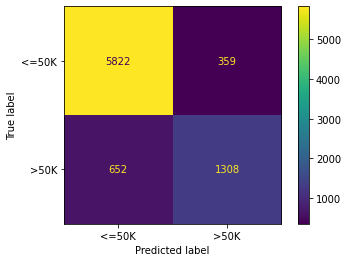

In [110]:
# Construct a confusion matrix
plot_confusion_matrix(lgbm_pipe, X_test, y_test)

# Gradient Boosting Model

In [111]:
# Instantiate the gradient boosting model
gbm_pipe = make_pipeline(col_transformer, GradientBoostingClassifier())

In [112]:
%%time
# Train the gradient boosting model
gbm_pipe.fit(X_train, y_train)

CPU times: user 8.5 s, sys: 9.51 ms, total: 8.51 s
Wall time: 8.48 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fad38d79950>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fad38f3ff50>)])),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [113]:
# Evaluate the model
y_train_pred = gbm_pipe.predict(X_train)
y_test_pred = gbm_pipe.predict(X_test)
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.92     18539
        >50K       0.80      0.59      0.68      5881

    accuracy                           0.87     24420
   macro avg       0.84      0.77      0.80     24420
weighted avg       0.86      0.87      0.86     24420

              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.92      6181
        >50K       0.80      0.60      0.68      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.77      0.80      8141
weighted avg       0.86      0.87      0.86      8141



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


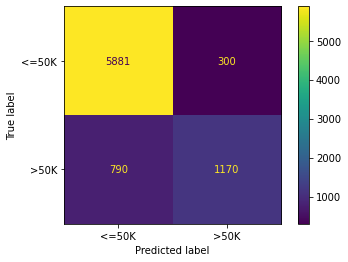

In [114]:
# Construct a confusion matrix
plot_confusion_matrix(gbm_pipe, X_test, y_test)

# Final Model

In [115]:
# Choose the final model
final_model = lgbm_pipe

The light gradient boosting model was chosen as the final model. It is significantly faster than the eXtreme Gradient Boosting model. The lgb model had a higher recall than the other models by 6-7%. This increased recall came at the cost of a decreased precision of about 3%. 

One could criticize our choice since a false positive would mean we are incorrectly predicting the income to be greater than 50k. By choosing a model with less precision, we risk misidentifying people in poverty.

In [116]:
# Get the hyperparameters of the final model
final_model.get_params()

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fad38d79950>),
                                 ('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fad38f3ff50>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__onehotencoder': OneHotEncoder(handle_unknown='ignore', sparse=False),
 'columntransformer__onehotencoder__categories': 'auto',
 'columntransformer__onehotencoder__drop': None,
 'columntransformer__onehotencoder__dtype': numpy.float64,
 'columntransformer__onehotencoder__handle_unknown': 'ignore',
 'columntransformer__onehotencoder__sparse': False,
 'columntransformer__remainde

In [117]:
# Make a param_grid for tuning
param_grid = {'lgbmclassifier__num_leaves': [40],
              'lgbmclassifier__learning_rate': [0.001, 0.01, 0.1, 1, 10, 100]}

In [121]:
# Tune the model with grid search
fm_grid_search = GridSearchCV(final_model, param_grid)
fm_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fad38d79950>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fad38f3ff50>)])),
                                       ('lgbmclas

In [119]:
# Get the best parameters of the tuned model
fm_grid_search.best_params_

{'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__num_leaves': 40}

In [122]:
# Evaluate the tuned model
tuned_model = fm_grid_search.best_estimator_
tuned_model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92      6181
        >50K       0.78      0.67      0.72      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.80      0.82      8141
weighted avg       0.87      0.87      0.87      8141



> We did not gain accuracy or precision by tuning our model, but our recall increased by 0.02. If we want to reduce false positives then we should try tuning the gradient boosting model.